# Graphics

In [2]:
import pandas as pd
import os
from IPython.display import display
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
#sns.set_style("whitegrid")
#sns.set_color_codes("dark")

cols = plotly.colors.DEFAULT_PLOTLY_COLORS
metrics = ["Local_Concordance",
    "Local_Fidelity",
    "Prescriptivity",
    "Conciseness",
    "Robustness"]

In [3]:
# Si existe el directorio "../../../csvs/""
if os.path.exists("../../../csvs/"):
    bigDf = []
    for file in os.listdir("../../../csvs/"):
        # Si el tamaño del archivo f"../csvs/{file}" es 0, no lo lee
        if os.stat("../../../csvs/" + file).st_size != 0:
            dataset = pd.read_csv(f"../../../csvs/{file}")
            bigDf.append(dataset)
    bigDf = pd.concat(bigDf)

    bigDf["num_features"] = bigDf["dim"]*bigDf["dim"]
    bigDf["Robustness"] = bigDf["robustness"]
    bigDf["Conciseness"] = bigDf["conciseness"]
    bigDf["Prescriptivity"] = bigDf["prescriptivity"]
    bigDf["Local_Fidelity"] = bigDf["local_fidelity"]
    bigDf["Local_Concordance"] = bigDf["local_concordance"]
    # Eliminar el anterio Experiments.csv
    if os.path.exists("Experiments.csv"):
        os.remove("Experiments.csv")
    if os.path.exists("Experiments_mean.csv"):
        os.remove("Experiments_mean.csv")
    bigDf = bigDf.groupby(["dataset","max_examples","xai_model","dim","sigma","index"]).mean()
    bigDf = bigDf.reset_index()
    bigDf.to_csv("Experiments_mean.csv")

In [ ]:
# Realizar un gráfico de caja para cada métrica agrupada por dataset y método
# El gráfico será de violin
res = pd.read_csv("Experiments_mean.csv")
LIME = res[(res.xai_model == "LIME" )]
# Cambiar el valor de la variable method en caso de que sea LIME a la concatenación de las variables method y sigma
# solo en caso de que method sea LIME.
m = LIME["xai_model"]
s = LIME["sigma"]
LIME["method"] =   m + "_" + s.apply(lambda x: str(x))
LIME = LIME.drop(labels=["sigma","max_examples","num_features"],axis=1)
LIME.reset_index(inplace=True)

for metric  in metrics:
    lista_figuras = []
    for j,method in enumerate(np.sort((LIME["method"].unique()))) :
        df =    LIME[LIME["method"] == method]
        media = df[metric].quantile(0.5)
        RIQ = df[metric].quantile(0.75) - df[metric].quantile(0.25)
        # No tener en cuenta los valores que se salgan del rango intercuartilico
        df_show = df[(df[metric] > media - 1.5*RIQ) & (df[metric] < media + 1.5*RIQ)]
        figura = go.Violin(x=df_show["dataset"],y=df_show[metric],name=method,box_visible=True,spanmode="hard",meanline_visible=True,meanline_color="black",meanline_width=2, points=False)
        lista_figuras.append(figura)
    fig = go.Figure(data=lista_figuras)
    fig.update_layout(title_text=metric,  title_x=0.5)
    fig.update_layout(violinmode='group')
    fig.show(renderer="svg")
    fig.write_image(f"./imagenes/{metric}_lime_violin.pdf")
    fig.write_image(f"./imagenes/{metric}_lime_violin.png",width=1000,height=500)

In [ ]:
# Realizar un gráfico de caja para cada métrica agrupada por dataset y método
res = pd.read_csv("Experiments_mean.csv")
SHAP = res[(res.xai_model == "SHAP" )]
# Cambiar el valor de la variable method en caso de que sea SHAP a la concatenación de las variables method y "_Global" en caso de ser sigma=0.5
# en caso de que sigma= 1, se cambia a la concatenación de method y "_Local"
SHAP["xai_model"] = SHAP["xai_model"] + "_" + SHAP["sigma"].apply(lambda x: "Global" if x == 0.5 else "Local")
SHAP = SHAP.drop(labels=["sigma","max_examples","num_features"],axis=1)
SHAP.reset_index(inplace=True)

for metric  in metrics:
    lista_figuras = []
    for j,xai_model in enumerate(np.sort((SHAP["xai_model"].unique()))) :
        df =    SHAP[SHAP["xai_model"] == xai_model]
        media = df[metric].quantile(0.5)
        RIQ = df[metric].quantile(0.75) - df[metric].quantile(0.25)
        # No tener en cuenta los valores que se salgan del rango intercuartilico
        df_show = df[(df[metric] > media - 1.5*RIQ) & (df[metric] < media + 1.5*RIQ)]
        figura = go.Violin(x=df_show["dataset"],y=df_show[metric],name=xai_model,box_visible=True,spanmode="hard",meanline_visible=True,meanline_color="black",meanline_width=2,points=False)
        lista_figuras.append(figura)
    fig = go.Figure(data=lista_figuras)
    fig.update_layout(title_text=metric,  title_x=0.5)
    fig.update_layout(violinmode='group')
    fig.show(renderer="svg")
    fig.write_image(f"./imagenes/{metric}_shap_violin.pdf")
    fig.write_image(f"./imagenes/{metric}_shap_violin.png",width=1000,height=500)


In [7]:
# Realizar el mismo gráfico de arriba pero juntando los datos de LIME y de SHAP
# Realizar un gráfico de violin para cada métrica agrupada por dataset y método
res = pd.read_csv("Experiments_mean.csv")
xai_method = res[(np.logical_or(res.xai_model == "LIME",  res.xai_model == "SHAP" ))]
# Cambiar el valor de la variable method a la concatenación de las variables method y sigma

m = xai_method["xai_model"]
s = xai_method["sigma"]
s_lime = s.apply(lambda x: str(x))
s = s.apply(lambda x: "Global" if x == 0.5 else ("Local" if x == 1 else str(x)))

xai_method["method"] =   m + "_" + s
xai_method = xai_method.drop(labels=["sigma","max_examples","num_features"],axis=1)
xai_method.reset_index(inplace=True)

for metric  in metrics:
    lista_figuras = []
    for j,method in enumerate(np.sort((xai_method["method"].unique()))) :
        df =    xai_method[xai_method["method"] == method]
        media = df[metric].quantile(0.5)
        RIQ = df[metric].quantile(0.75) - df[metric].quantile(0.25)
        # No tener en cuenta los valores que se salgan del rango intercuartilico
        df_show = df[(df[metric] > media - 1.5*RIQ) & (df[metric] < media + 1.5*RIQ)]
        figura = go.Violin(x=df_show["dataset"],y=df_show[metric],name=method,box_visible=True,spanmode="hard",meanline_visible=True,meanline_color="black",meanline_width=2, points=False)
        lista_figuras.append(figura)
    fig = go.Figure(data=lista_figuras)
    fig.update_layout(title_text=metric,  title_x=0.5)
    fig.update_layout(violinmode='group')
    fig.show(renderer="svg")
    fig.write_image(f"./imagenes/{metric}_violin.pdf")
    fig.write_image(f"./imagenes/{metric}_violin.png",width=1000,height=500)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

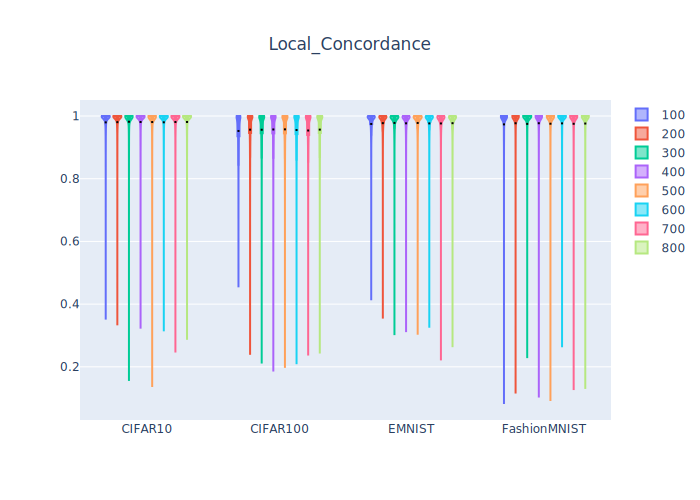

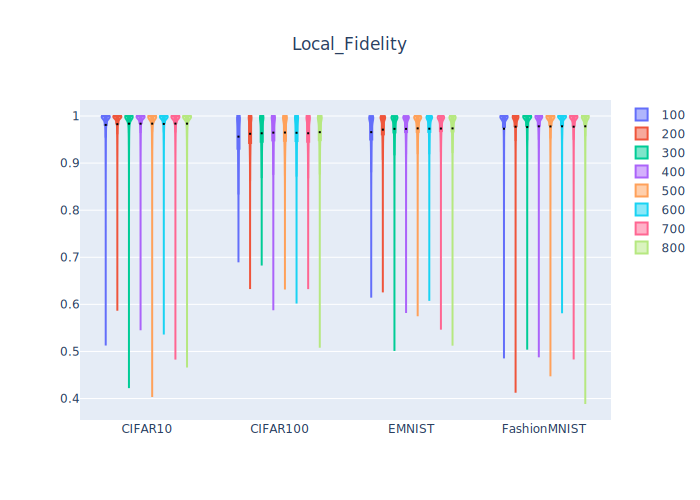

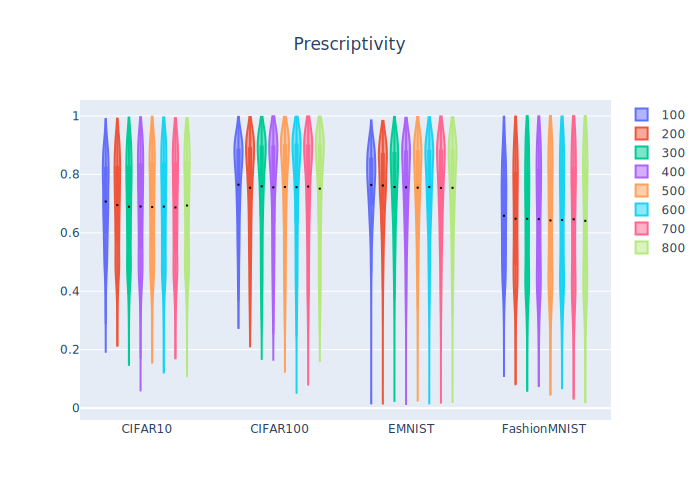

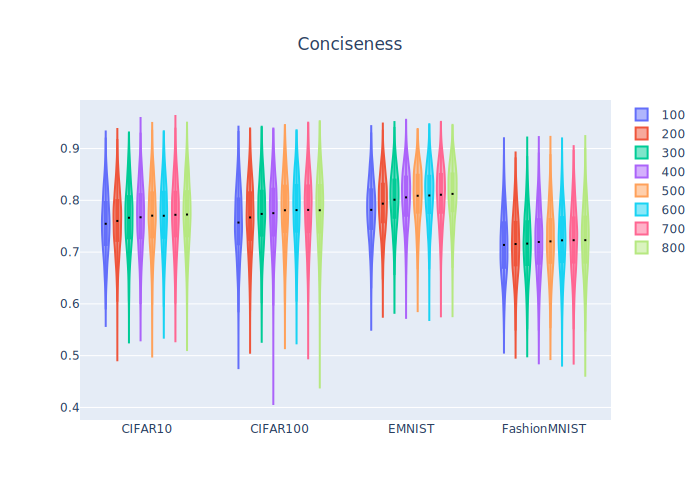

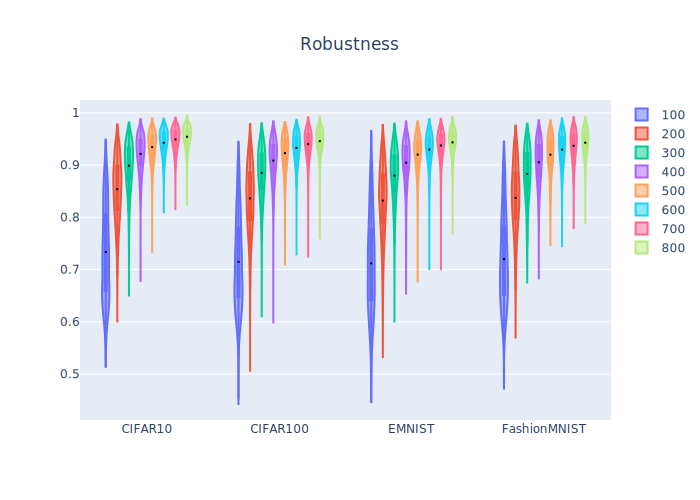

In [6]:
res = pd.read_csv("Experiments_mean.csv")
max_examples = res[(res.xai_model == "LIME")]
#num_features = num_features.drop(labels=["sigma","num_features"],axis=1)

for metric  in metrics:
    lista_figuras = []
    for j,max_example in enumerate(np.sort(max_examples["max_examples"].unique())):
        df =    max_examples[max_examples["max_examples"] == max_example]
        media = df[metric].quantile(0.5)
        RIQ = df[metric].quantile(0.75) - df[metric].quantile(0.25)
        # No tener en cuenta los valores que se salgan del rango intercuartilico
        df_show = df[(df[metric] > media - 1.5*RIQ) & (df[metric] < media + 1.5*RIQ)]
        figura = go.Violin(x=df["dataset"],y=df[metric],name=str(max_example),box_visible=True,spanmode="hard",meanline_visible=True,meanline_color="black",meanline_width=2,points=False)
        lista_figuras.append(figura)
    fig = go.Figure(data=lista_figuras)
    fig.update_layout(title_text=metric,  title_x=0.5)
    fig.update_layout(violinmode='group')
    fig.show(renderer="svg")
    fig.write_image(f"./imagenes/{metric}_violin_lime_max_examples.pdf")
    fig.write_image(f"./imagenes/{metric}_violin_lime_max_examples.png",width=1000,height=500)

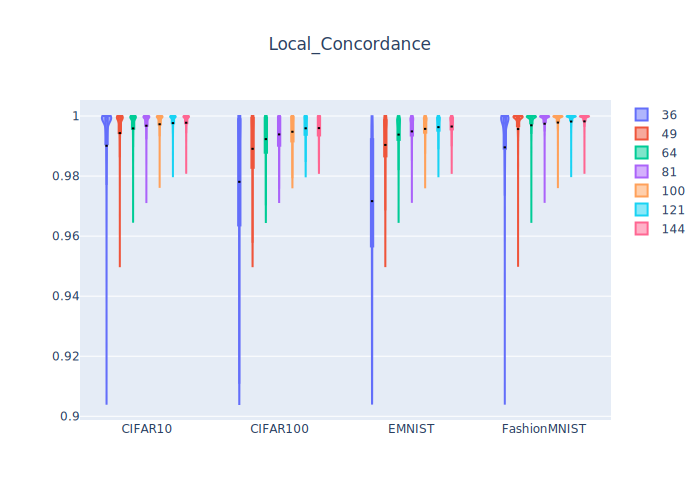

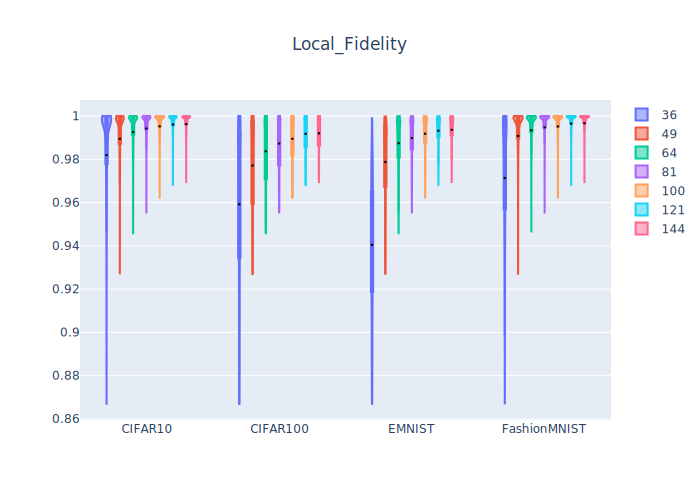

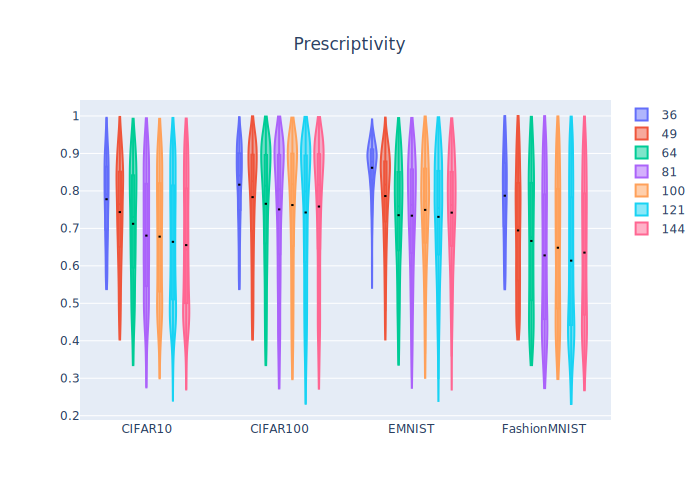

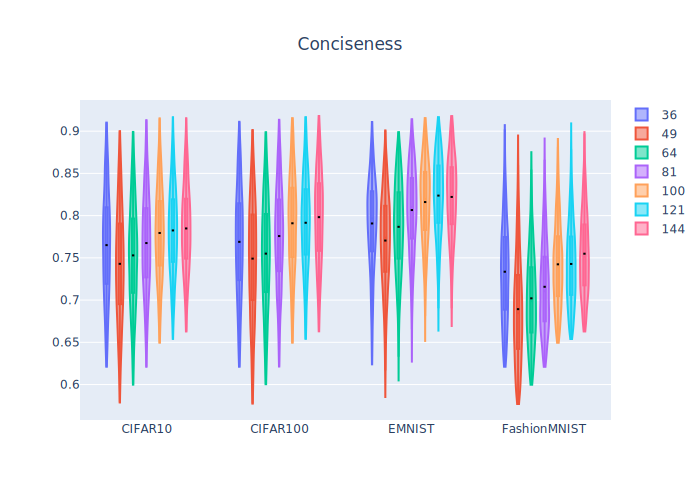

In [8]:
res = pd.read_csv("Experiments_mean.csv")
num_features = res[(res.xai_model == "LIME")]
for metric  in metrics:
    lista_figuras = []
    for j,num_feature in enumerate(np.sort(num_features["num_features"].unique())):
        df =    num_features[num_features["num_features"] == num_feature]
        median = df[metric].quantile(0.5)
        RIQ = df[metric].quantile(0.75) - df[metric].quantile(0.25)
        # No tener en cuenta los valores que se salgan del rango intercuartilico   
        df_show = df[(df[metric] > median - 1.5*RIQ) & (df[metric] < median + 1.5*RIQ)]
        figura = go.Violin(x=df_show["dataset"],y=df_show[metric],name=str(int(num_feature)),box_visible=True,spanmode="hard",meanline_visible=True,meanline_color="black",meanline_width=2,points=False)
        lista_figuras.append(figura)
    fig = go.Figure(data=lista_figuras)
    fig.update_layout(title_text=metric,  title_x=0.5)
    fig.update_layout(violinmode='group')
    fig.show(renderer="svg")
    fig.write_image(f"./imagenes/{metric}_violin_lime_num_features.pdf")
    fig.write_image(f"./imagenes/{metric}_violin_lime_num_features.png",width=1000,height=500)